In [226]:
import ast
import pickle

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
pd.set_option('display.max_columns', 50)

In [227]:
data = pd.read_csv("../data/data_processed/ml_data_processed_final.csv")
# diffs = new_data['num__odi_final'].to_numpy() != data['num__odi_final'].to_numpy()

In [228]:

X = data.drop(['spinal_risk_score'], axis=1)  # All columns except the last one are predictors
y = data['spinal_risk_score'].to_numpy()   # The last column is the response variable


# Dropping additional columns
X = X.drop(['num__height_m', 'num__ADI_STATERNK'], axis=1)

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
# Validation split for Linear models
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

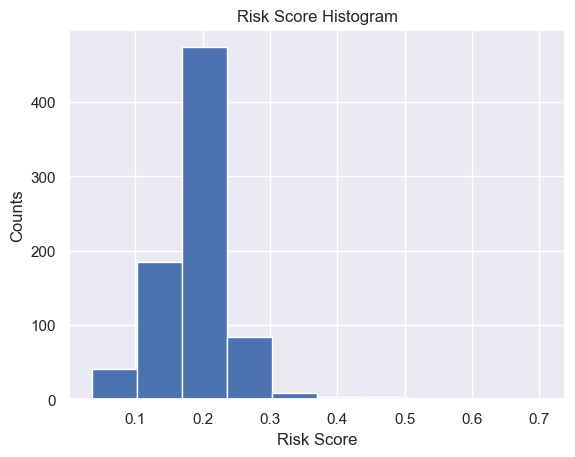

In [230]:
plt.hist(y)
plt.xlabel('Risk Score')
plt.ylabel('Counts')
plt.title('Risk Score Histogram')
plt.show()

In [231]:
# https://medium.datadriveninvestor.com/introduction-31c985114aa1

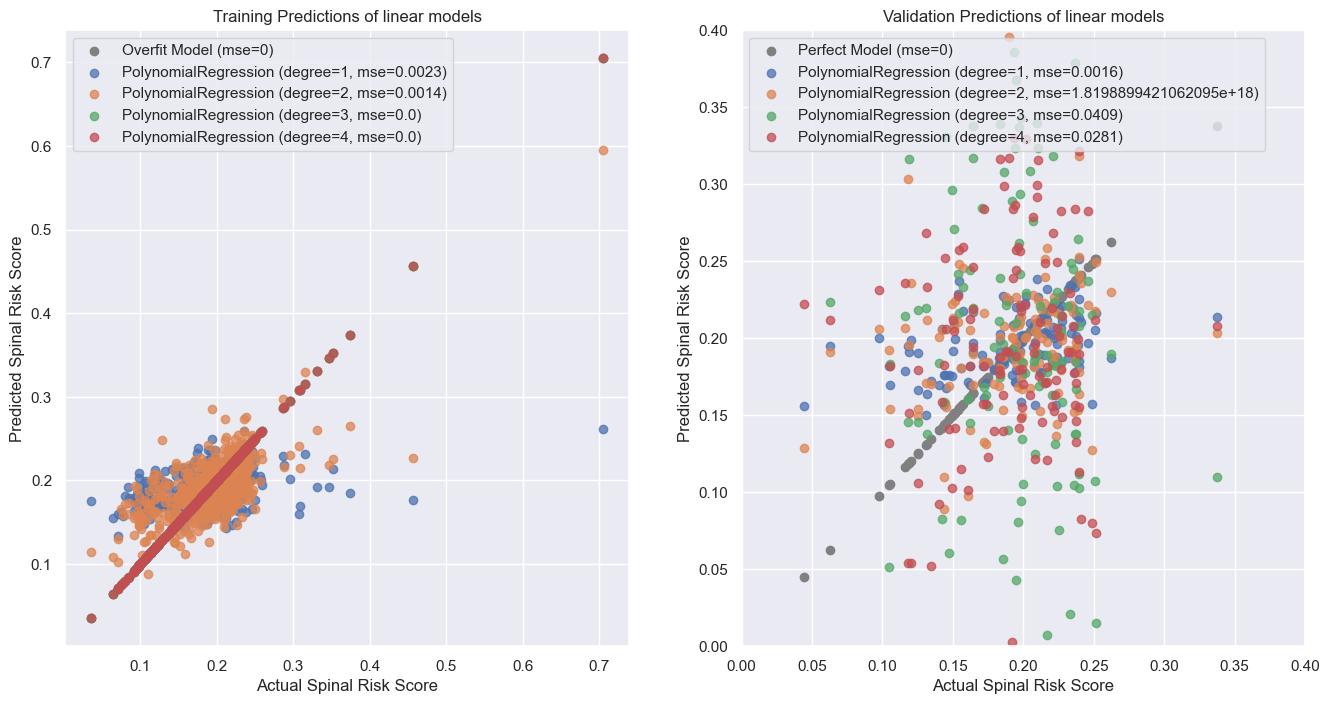

In [232]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(y_train2, y_train2, c='gray', label='Overfit Model (mse=0)')
axes[1].scatter(y_val, y_val, c='gray', label='Perfect Model (mse=0)')

# Linear Models
# Polynomial Regression
for degree in range(1, 5):
    polyreg_model = Pipeline([
                    # ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=degree)),
                    ('linear', LinearRegression(fit_intercept=False))])
    # fit to an order-3 polynomial data
    polyreg_model = polyreg_model.fit(X_train2, y_train2)

    y_train_pred = polyreg_model.predict(X_train2)
    y_val_pred = polyreg_model.predict(X_val)
    
    train_mse = mean_squared_error(y_train_pred, y_train2)
    val_mse = mean_squared_error(y_val_pred, y_val)

    axes[0].scatter(y_train2, y_train_pred, label=f'PolynomialRegression (degree={degree}, mse={np.round(train_mse, 4)})', alpha=0.75)
    axes[1].scatter(y_val, y_val_pred, label=f'PolynomialRegression (degree={degree}, mse={np.round(val_mse, 4)})', alpha=0.75)

# axes[0].set_xlim(0, 0.4)
# axes[0].set_ylim(0, 0.4)
axes[0].set_xlabel("Actual Spinal Risk Score")
axes[0].set_ylabel("Predicted Spinal Risk Score")
axes[0].set_title(f"Training Predictions of linear models")
axes[0].legend(loc='upper left')


axes[1].set_xlim(0, 0.4)
axes[1].set_ylim(0, 0.4)
axes[1].set_xlabel("Actual Spinal Risk Score")
axes[1].set_ylabel("Predicted Spinal Risk Score")
axes[1].set_title(f"Validation Predictions of linear models")
axes[1].legend(loc='upper left')
plt.show()

In [233]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import shap
import numpy as np




# Define models
# Define models
models = {
    # 'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    # 'Gradient Boosting Regression': GradientBoostingRegressor(),
    # 'XGBoost Regression': XGBRegressor(),
    # 'Ridge Regression': Ridge(),
    # 'Lasso Regression': Lasso(),
    # 'Elastic Net Regression': ElasticNet(),
    # 'SVM Regression': SVR(),
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Decision Tree Regression': {
        'max_depth': list(np.arange(10, 110, 10)),
        'min_samples_split': np.arange(2, 20, 1),   # 2 to 20, 1
        'min_samples_leaf': np.arange(1, 11),
        'max_features': list(np.arange(0.1, 1.0, 0.1)),
    },
    'Random Forest Regression': {
        'n_estimators': np.arange(100, 1100, 100),
        'max_depth': list(np.arange(10, 110, 10)),
        'min_samples_split': np.arange(2, 11),
        'min_samples_leaf': np.arange(1, 11),
        'max_features': list(np.arange(0.1, 1.0, 0.1)),
        'bootstrap': [True, False],
    },
    'XGBoost Regression': {
        'n_estimators': np.arange(50, 200, 10),
        'learning_rate': np.linspace(0.005, 0.1, 25),
        'max_depth': np.arange(2, 12, 2),
        'subsample': np.linspace(0.5, 1, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'gamma': np.linspace(0, 0.5, 5),
        'colsample_bytree': np.linspace(0.5, 1, 5)
    },
    'Gradient Boosting Regression': {
        'n_estimators': np.arange(50, 200, 10),
        'learning_rate': np.linspace(0.005, 0.1, 25),
        'max_depth': np.arange(2, 12, 2),
        'min_samples_split': np.arange(2, 20, 1),   # 2 to 20, 1
        'min_samples_leaf': np.arange(1, 20, 1), 
    },
    'SVM Regression': {
        'C': np.linspace(0.5, 20, 30),
        'gamma': np.logspace(start=0, stop=-3, num=4, base=10),
        'kernel': ['linear', 'rbf']
    },
    'Ridge Regression': {
        'alpha': np.logspace(-4, 4, 40),  # Regularization strength
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'Lasso Regression': {
        'alpha': np.logspace(-4, 4, 40),  # Regularization strength
        'max_iter': [1000, 5000, 10000],  # Maximum number of iterations
    },
    'Elastic Net Regression': {
        'alpha': np.logspace(-4, 4, 40),  # Regularization strength
        'l1_ratio': np.linspace(0, 1, 40),  # The ElasticNet mixing parameter
        'max_iter': [1000, 5000, 10000],  # Maximum number of iterations
    },
}
SEARCH_METHOD = 'random'
degree = 2
# Perform hyperparameter tuning and model training
predictions = {}
train_predictions = {}
best_models = {}
for model_name, model in models.items():
    if model_name in param_grids:
        if SEARCH_METHOD == 'grid':
            # Perform hyperparameter tuning
            grid_search = GridSearchCV(model, param_grids[model_name], cv=6, scoring='neg_mean_squared_error')
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=degree)),
                ('grid_search', grid_search)
            ])
        else:
            # Perform hyperparameter tuning using RandomizedSearchCV
            randomized_search = RandomizedSearchCV(model, param_grids[model_name], n_iter=300, cv=10, scoring='neg_mean_squared_error', random_state=42)
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=degree)),
                ('randomized_search', randomized_search)
            ])
    else:
        # No hyperparameter tuning for models without param grids
        pipeline = Pipeline([
            ('model', model)
        ])
    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)

    # Accessing the best validation score
    if SEARCH_METHOD == 'grid':
        best_validation_score = grid_search.best_score_
    else:
        best_validation_score = randomized_search.best_score_
    best_validation_mse = abs(best_validation_score)  # Convert to positive MSE
    
    print(f'{model_name} - Best Validation Mean Squared Error: {best_validation_mse}')

    # y_pred = pipeline.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred)
    # print(f'{model_name} - Mean Squared Error: {mse}')
    # predictions[model_name] = y_pred
    train_predictions[model_name] = y_train_pred
    best_models[model_name] = pipeline
    rsearch_df = pd.DataFrame(randomized_search.cv_results_)
    # rsearch_df.to_csv(f'../data/model_training/polydegree{degree}/cv_results_{model_name}.csv', index=False)

Random Forest Regression - Best Validation Mean Squared Error: 0.0023443640602440557


In [220]:
# Define models
models = {
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'XGBoost Regression': XGBRegressor(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
    'SVM Regression': SVR(),
}

In [221]:
# Analyzing the results of the random search
degrees = [1, 2]
start = 1
for degree in degrees:
    for model_name in models.keys():
        cv_results = pd.read_csv(f'../data/model_training/polydegree{degree}/cv_results_{model_name}.csv')
        num_rows = cv_results.shape[0]
        cv_results['degree'] = [degree for _ in range(num_rows)]
        cv_results['model_name'] = [model_name for _ in range(num_rows)]
        if start == 1:
            final_cv_results = cv_results
            start = 0
        else:
            final_cv_results = pd.concat([final_cv_results, cv_results], axis=0)

final_cv_results['mean_test_score'] = final_cv_results['mean_test_score'] * -1
final_cv_results = final_cv_results.drop_duplicates(subset=['params', 'model_name', 'degree'])

FixedFormatter should only be used together with FixedLocator


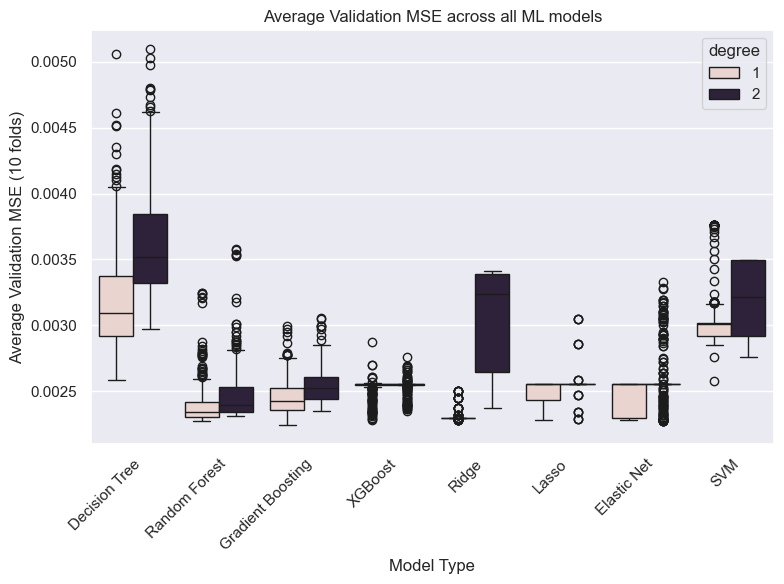

In [222]:
labels = [' '.join(model_name.split(' ')[:-1]) for model_name in final_cv_results['model_name'].unique()]

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(final_cv_results, x='model_name', y='mean_test_score', hue='degree', ax=ax)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Average Validation MSE (10 folds)')
ax.set_xlabel('Model Type')
ax.set_title('Average Validation MSE across all ML models')
plt.tight_layout()
plt.savefig('../figures/hp_tuning/all_models_validation_mse.png')
plt.show()

FixedFormatter should only be used together with FixedLocator


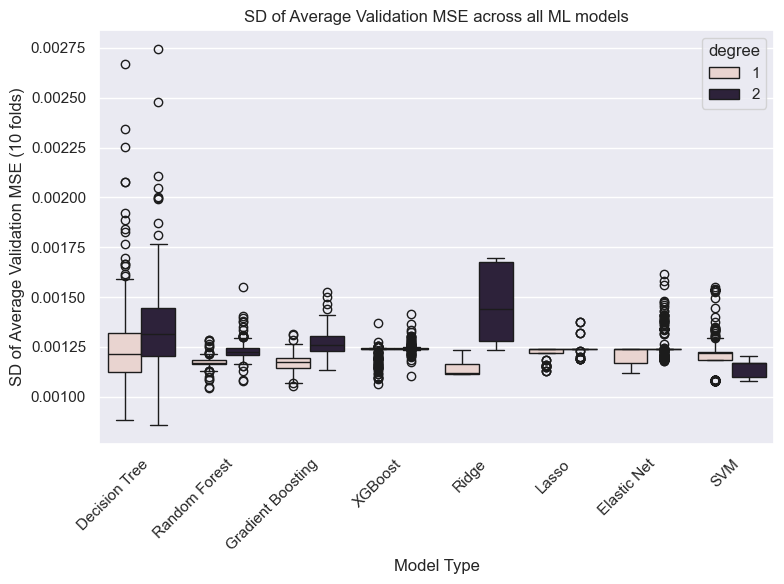

In [223]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(final_cv_results, x='model_name', y='std_test_score', hue='degree', ax=ax)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('SD of Average Validation MSE (10 folds)')
ax.set_xlabel('Model Type')
ax.set_title('SD of Average Validation MSE across all ML models')
plt.tight_layout()
plt.savefig('../figures/hp_tuning/all_models_validation_stdev.png')
plt.show()

In [224]:
best_models_df = final_cv_results[final_cv_results['rank_test_score'] == 1][['model_name', 'degree', 'params', 'mean_test_score']]

In [225]:
best_models_df

,model_name,degree,params,mean_test_score
125,Decision Tree Regression,1,"{'min_samples_split': 12, 'min_samples_leaf': ...",0.002586
269,Random Forest Regression,1,"{'n_estimators': 200, 'min_samples_split': 3, ...",0.002270
27,Gradient Boosting Regression,1,"{'n_estimators': 150, 'min_samples_split': 10,...",0.002243
119,XGBoost Regression,1,"{'subsample': 1.0, 'n_estimators': 170, 'min_c...",0.002280
101,Ridge Regression,1,"{'solver': 'lsqr', 'alpha': 78.47599703514607}",0.002284
6,Lasso Regression,1,"{'max_iter': 1000, 'alpha': 0.0006951927961775...",0.002283
7,Lasso Regression,1,"{'max_iter': 5000, 'alpha': 0.0006951927961775...",0.002283
8,Lasso Regression,1,"{'max_iter': 10000, 'alpha': 0.000695192796177...",0.002283
81,Elastic Net Regression,1,"{'max_iter': 10000, 'l1_ratio': 0.631578947368...",0.002280
7,SVM Regression,1,"{'kernel': 'rbf', 'gamma': 0.001, 'C': 0.5}",0.002581


In [211]:
# Fitting the best models on the other split
fitted_models_df = best_models_df.copy()
scores_dict = {'train_mse':[], 'train_r2':[], 'test_mse':[], 'test_r2':[]}
for row in best_models_df.itertuples():
    model = models[row.model_name]
    model = model.set_params(**ast.literal_eval(row.params))
    X_train_transform = PolynomialFeatures(degree=row.degree).fit_transform(X_train)
    X_test_transform = PolynomialFeatures(degree=row.degree).fit_transform(X_test)
    model.fit(X_train_transform, y_train)
    y_train_pred = model.predict(X_train_transform)
    y_test_pred = model.predict(X_test_transform)
    scores_dict['train_mse'].append(mean_squared_error(y_true=y_train, y_pred=y_train_pred))
    scores_dict['train_r2'].append(r2_score(y_true=y_train, y_pred=y_train_pred))
    scores_dict['test_mse'].append(mean_squared_error(y_true=y_test, y_pred=y_test_pred))
    scores_dict['test_r2'].append(r2_score(y_true=y_test, y_pred=y_test_pred))
fitted_models_df['train mse'] = scores_dict['train_mse']
fitted_models_df['train R2'] = scores_dict['train_r2']
fitted_models_df['test mse'] = scores_dict['test_mse']
fitted_models_df['test R2'] = scores_dict['test_r2']

fitted_models_unique_df = fitted_models_df.drop_duplicates(subset=['model_name', 'degree', 'test mse', 'test R2'])
    

In [212]:
fitted_models_unique_df.head()

,model_name,degree,params,mean_test_score,train mse,train R2,test mse,test R2
125,Decision Tree Regression,1,"{'min_samples_split': 12, 'min_samples_leaf': ...",0.002586,0.001958,0.230387,0.003885,-0.011180
269,Random Forest Regression,1,"{'n_estimators': 200, 'min_samples_split': 3, ...",0.002270,0.001301,0.488521,0.003578,0.068568
27,Gradient Boosting Regression,1,"{'n_estimators': 150, 'min_samples_split': 10,...",0.002243,0.001771,0.303667,0.003653,0.049174
119,XGBoost Regression,1,"{'subsample': 1.0, 'n_estimators': 170, 'min_c...",0.002280,0.001900,0.253070,0.003631,0.054878
101,Ridge Regression,1,"{'solver': 'lsqr', 'alpha': 78.47599703514607}",0.002284,0.002165,0.148790,0.003414,0.111290


In [213]:
# Linear models
linear_models = {'model_name':[], 'degree':[], 'train mse':[], 'train R2':[], 'test mse':[], 'test R2':[]}
for degree in range(1, 5):
    polyreg_model = Pipeline([
                    # ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=degree)),
                    ('linear', LinearRegression(fit_intercept=False))])
    # fit to an order-3 polynomial data
    polyreg_model = polyreg_model.fit(X_train, y_train)
    y_train_pred = polyreg_model.predict(X_train)
    y_test_pred = polyreg_model.predict(X_test)
    linear_models['model_name'].append('Linear Regression')
    linear_models['degree'].append(degree)
    linear_models['train mse'].append(mean_squared_error(y_true=y_train, y_pred=y_train_pred))
    linear_models['train R2'].append(r2_score(y_true=y_train, y_pred=y_train_pred))
    linear_models['test mse'].append(mean_squared_error(y_true=y_test, y_pred=y_test_pred))
    linear_models['test R2'].append(r2_score(y_true=y_test, y_pred=y_test_pred))
    # print("number of coefficients:", len(polyreg_model.named_steps['linear'].coef_))
    # print("coefficients:", polyreg_model.named_steps['linear'].coef_)



In [214]:
fitted_models_with_linear_df = pd.concat([fitted_models_unique_df, pd.DataFrame(linear_models)])

In [218]:
fitted_models_with_linear_df.sort_values(by='test mse')

,model_name,degree,params,mean_test_score,train mse,train R2,test mse,test R2
6,Lasso Regression,1,"{'max_iter': 1000, 'alpha': 0.0006951927961775...",0.002283,2.169787e-03,0.147025,0.003393,0.116855
81,Elastic Net Regression,1,"{'max_iter': 10000, 'l1_ratio': 0.631578947368...",0.002280,2.188221e-03,0.139779,0.003399,0.115217
101,Ridge Regression,1,"{'solver': 'lsqr', 'alpha': 78.47599703514607}",0.002284,2.165299e-03,0.148790,0.003414,0.111290
0,Linear Regression,1,NaN,NaN,2.148331e-03,0.155460,0.003416,0.110902
92,Elastic Net Regression,2,"{'max_iter': 5000, 'l1_ratio': 0.7894736842105...",0.002273,2.144135e-03,0.157109,0.003431,0.106783
12,Lasso Regression,2,"{'max_iter': 1000, 'alpha': 0.004832930238571752}",0.002289,2.219154e-03,0.127618,0.003515,0.084954
122,Ridge Regression,2,"{'solver': 'lsqr', 'alpha': 1438.44988828766}",0.002373,2.020198e-03,0.205831,0.003555,0.074654
269,Random Forest Regression,2,"{'n_estimators': 200, 'min_samples_split': 3, ...",0.002311,9.709448e-04,0.618308,0.003563,0.072433
269,Random Forest Regression,1,"{'n_estimators': 200, 'min_samples_split': 3, ...",0.002270,1.301094e-03,0.488521,0.003578,0.068568
7,SVM Regression,1,"{'kernel': 'rbf', 'gamma': 0.001, 'C': 0.5}",0.002581,2.407851e-03,0.053439,0.003579,0.068312


FixedFormatter should only be used together with FixedLocator


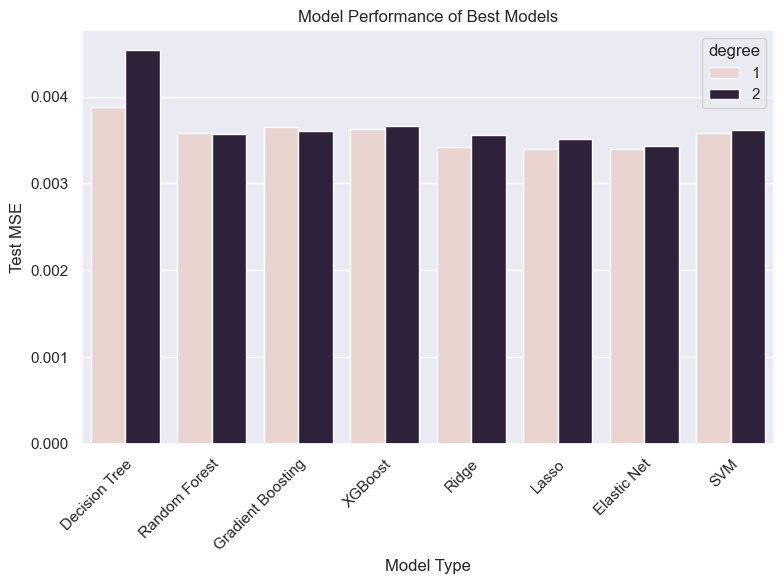

In [215]:
labels = [' '.join(model_name.split(' ')[:-1]) for model_name in final_cv_results['model_name'].unique()] # + ['Linear Regression']
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(fitted_models_unique_df, x='model_name', y='test mse', hue='degree', ax=ax)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Test MSE')
ax.set_xlabel('Model Type')
ax.set_title('Model Performance of Best Models')
plt.tight_layout()
plt.savefig('../figures/hp_tuning/best_models_test_mse.png')
plt.show()

FixedFormatter should only be used together with FixedLocator


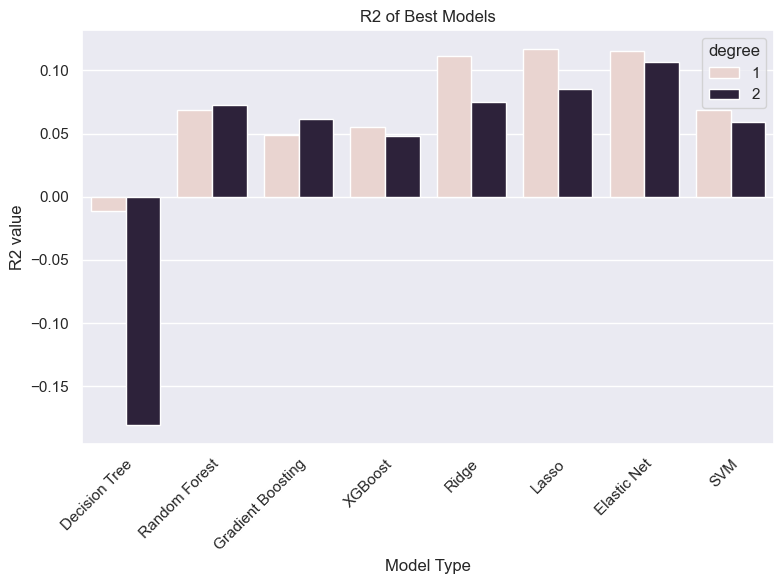

In [216]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(fitted_models_unique_df, x='model_name', y='test R2', hue='degree', ax=ax)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('R2 value')
ax.set_xlabel('Model Type')
ax.set_title('R2 of Best Models')
plt.tight_layout()
plt.savefig('../figures/hp_tuning/best_models_test_R2.png')
plt.show()

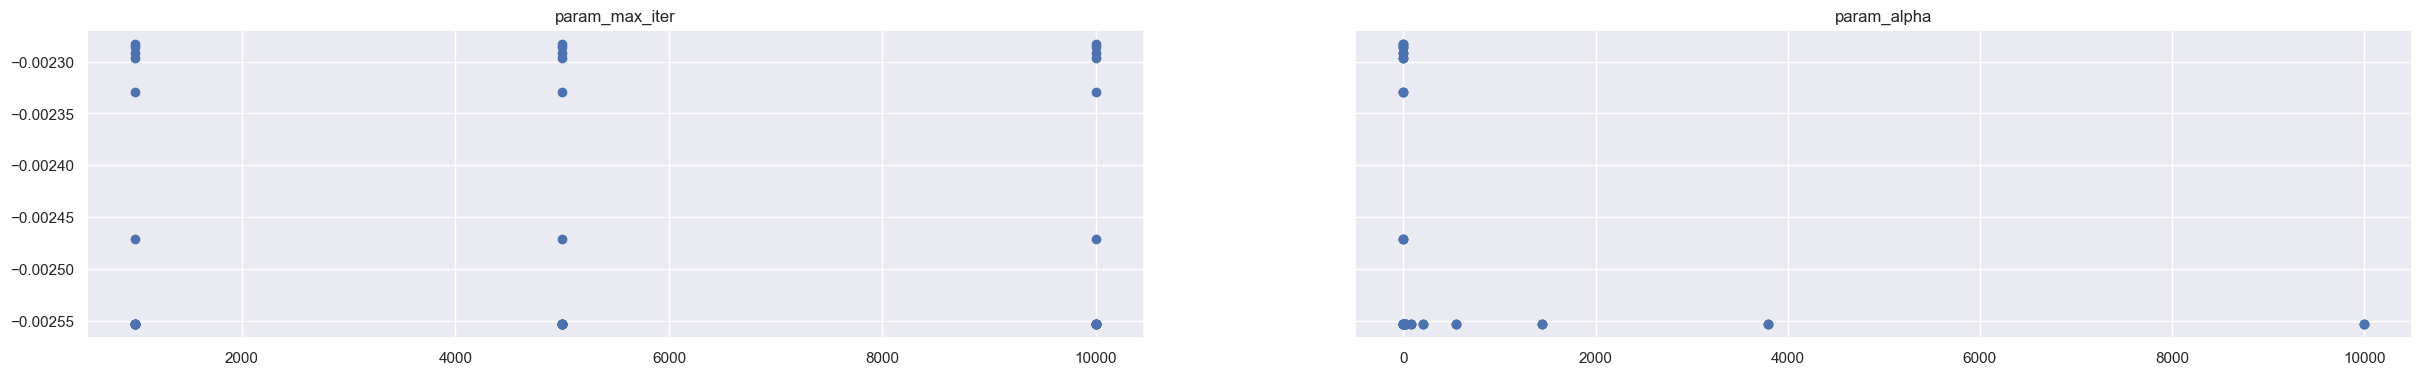

In [24]:
trial = 1
cv_results = lasso_results
param_df = cv_results.filter(regex='param_')
num_params = param_df.shape[1]

fig, axes = plt.subplots(1, num_params, figsize=(30, 4), sharey=True)
for i, ax in enumerate(axes):
    ax.scatter(param_df.iloc[:, i], cv_results['mean_test_score'])
    ax.set_title(f'{param_df.columns[i]}')

# fig.savefig(f'../figures/hp_tuning/randomforest_hp_correlations{trial}.png')


In [185]:
fitted_models_unique_df.sort_values(by='test mse')

,model_name,degree,params,mean_test_score,train_mse,train R2,test mse,test R2
6,Lasso Regression,1,"{'max_iter': 1000, 'alpha': 0.0006951927961775...",0.002283,0.002170,0.147025,0.003393,0.116855
81,Elastic Net Regression,1,"{'max_iter': 10000, 'l1_ratio': 0.631578947368...",0.002280,0.002188,0.139779,0.003399,0.115217
101,Ridge Regression,1,"{'solver': 'lsqr', 'alpha': 78.47599703514607}",0.002284,0.002165,0.148790,0.003414,0.111290
92,Elastic Net Regression,2,"{'max_iter': 5000, 'l1_ratio': 0.7894736842105...",0.002273,0.002144,0.157109,0.003431,0.106783
12,Lasso Regression,2,"{'max_iter': 1000, 'alpha': 0.004832930238571752}",0.002289,0.002219,0.127618,0.003515,0.084954
122,Ridge Regression,2,"{'solver': 'lsqr', 'alpha': 1438.44988828766}",0.002373,0.002020,0.205831,0.003555,0.074654
269,Random Forest Regression,2,"{'n_estimators': 200, 'min_samples_split': 3, ...",0.002311,0.000982,0.614126,0.003576,0.069069
7,SVM Regression,1,"{'kernel': 'rbf', 'gamma': 0.001, 'C': 0.5}",0.002581,0.002408,0.053439,0.003579,0.068312
238,Gradient Boosting Regression,2,"{'n_estimators': 120, 'min_samples_split': 5, ...",0.002351,0.001855,0.270826,0.003606,0.061230
7,SVM Regression,2,"{'kernel': 'rbf', 'gamma': 0.001, 'C': 0.5}",0.002758,0.002160,0.150909,0.003614,0.059155


In [189]:
best_model_params = fitted_models_unique_df.sort_values(by='test mse').iloc[0, :]

final_model = models[best_model_params.model_name]
final_model = final_model.set_params(**ast.literal_eval(best_model_params.params))
X_train_transform = PolynomialFeatures(degree=best_model_params.degree).fit_transform(X)
final_model = final_model.fit(X, y)

# Saving final model to a pickle


In [30]:
plot_df = param_df.copy()
plot_df['mean_test_score'] = cv_results['mean_test_score']

import plotly.express as px


fig = px.scatter_3d(plot_df, x='param_n_estimators', y='param_max_depth', z='param_learning_rate',
              color='mean_test_score', size_max=5)
fig.show()

In [101]:
best_models['XGBoost Regression'].named_steps['randomized_search'].best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02875, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=110, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

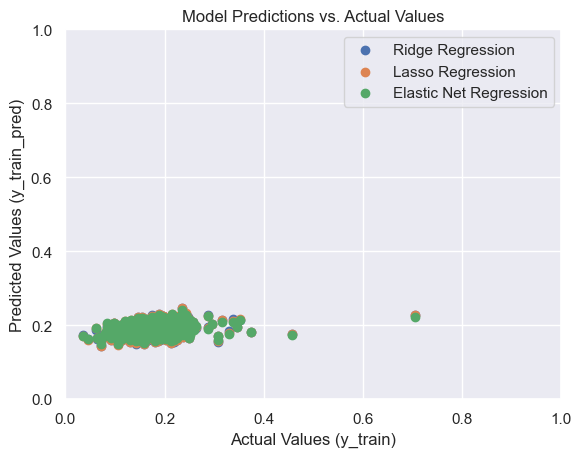

In [25]:
for model_name, y_train_pred in train_predictions.items():
    plt.scatter(y_train, y_train_pred, label=model_name)

plt.xlabel('Actual Values (y_train)')
plt.ylabel('Predicted Values (y_train_pred)')
plt.title('Model Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


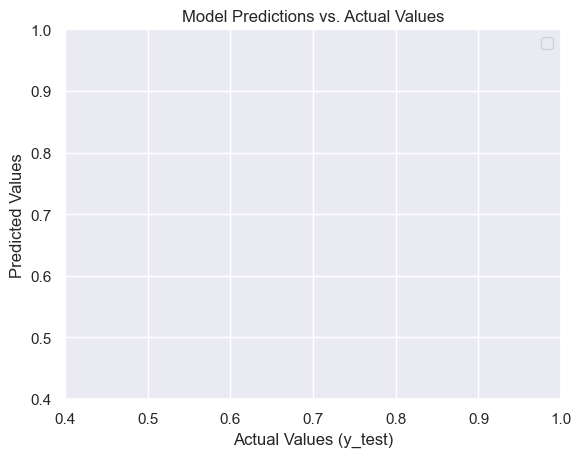

In [104]:
for model_name, y_pred in predictions.items():
    plt.scatter(y_test, y_pred, label=model_name)

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs. Actual Values')
plt.xlim(0.4, 1)
plt.ylim(0.4, 1)
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


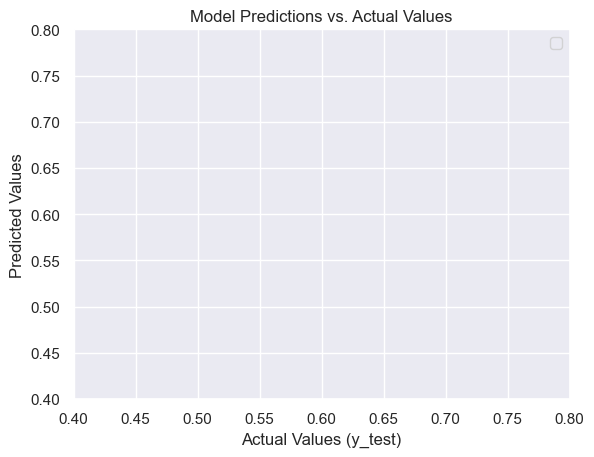

In [105]:
for model_name, y_pred in predictions.items():
    if model_name in ['XGBoost Regression', 'Gradient Boosting Regression', 'SVM Regression']:
        plt.scatter(y_test, y_pred, label=model_name)

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.xlim([0.4, 0.8])
plt.ylim([0.4, 0.8])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


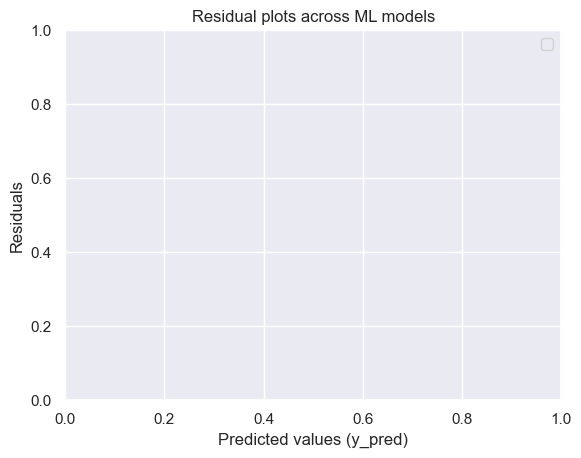

In [106]:
for model_name, y_pred in predictions.items():
    if model_name not in []:
        plt.scatter(y_pred, y_test - y_pred, label=model_name)

plt.xlabel('Predicted values (y_pred)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


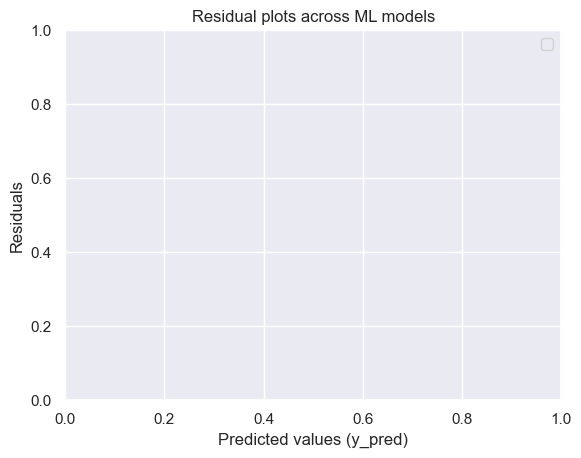

In [107]:
for model_name, y_pred in predictions.items():
    if model_name in ['Linear Regression', 'Random Forest Regression']:
        plt.scatter(y_pred, y_test - y_pred, label=model_name)

plt.xlabel('Predicted values (y_pred)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


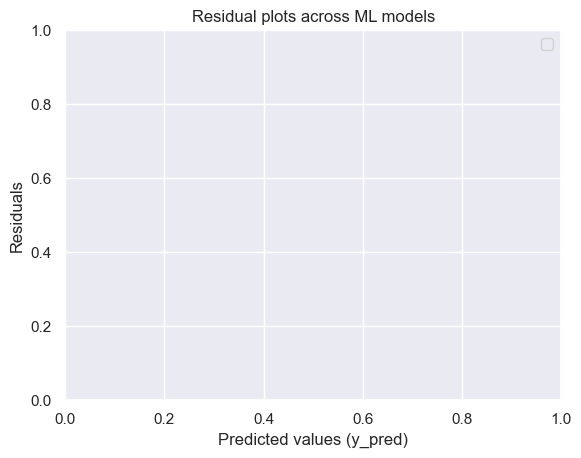

In [108]:
for model_name, y_pred in predictions.items():
    if model_name in ['XGBoost Regression', 'Gradient Boosting Regression', 'SVM Regression']:
        plt.scatter(y_pred, y_test - y_pred, label=model_name)

plt.xlabel('Predicted values (y_pred)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


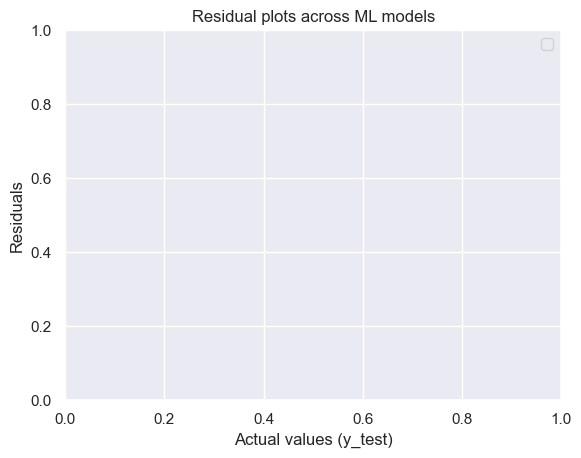

In [109]:
for model_name, y_pred in predictions.items():
    if model_name in ['XGBoost Regression', 'Gradient Boosting Regression', 'SVM Regression']:
        plt.scatter(y_test, y_test - y_pred, label=model_name)

plt.xlabel('Actual values (y_test)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
best_models['Linear Regression'].get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])>

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error', cv=5)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = -np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training error', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, valid_scores_mean, label='Validation error', color='orange')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color='orange')
    
    plt.xlabel('Training examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


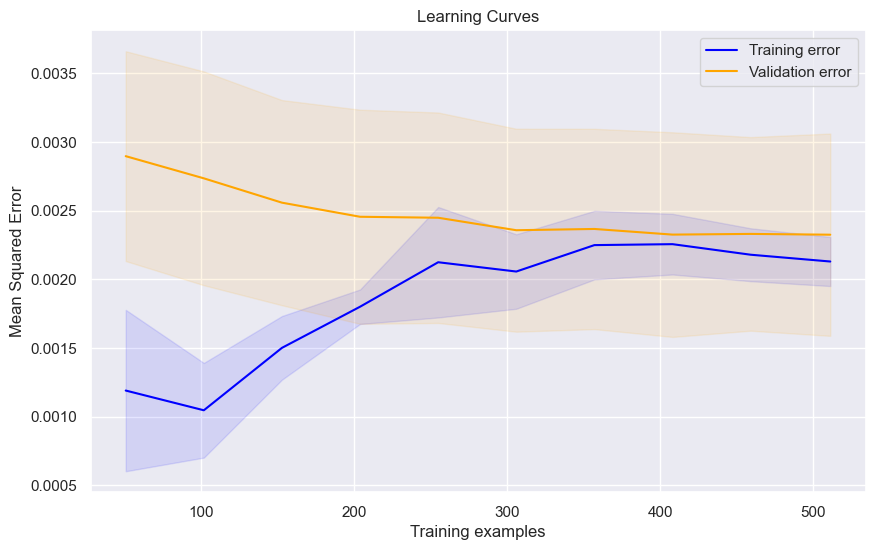

In [112]:
# Assuming you have your X_train and y_train ready
# Let's visualize learning curves for one of your models, for example, RandomForestRegressor
model = LinearRegression()
plot_learning_curves(model, X_train, y_train)

In [113]:
best_models['Random Forest Regression'].named_steps['grid_search'].best_estimator_

KeyError: 'Random Forest Regression'

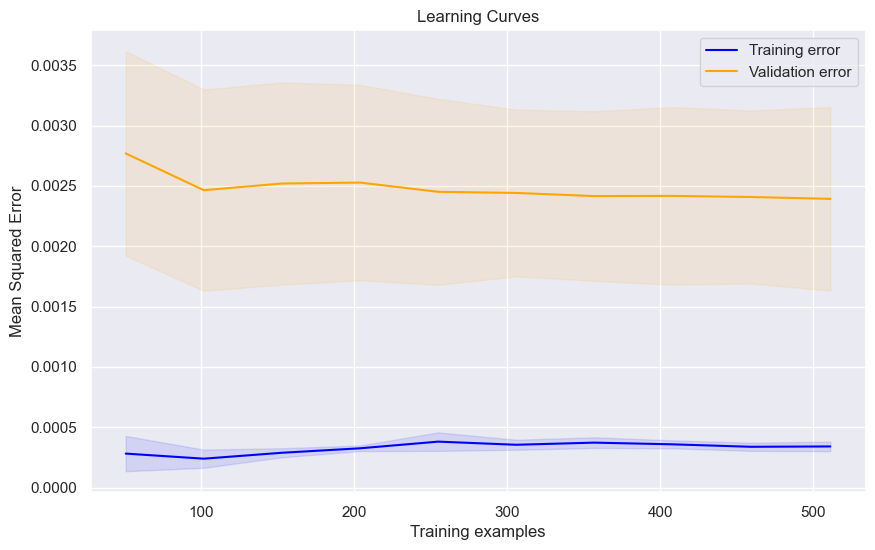

In [114]:
model = RandomForestRegressor(max_depth=20, n_estimators=300)
plot_learning_curves(model, X_train, y_train)

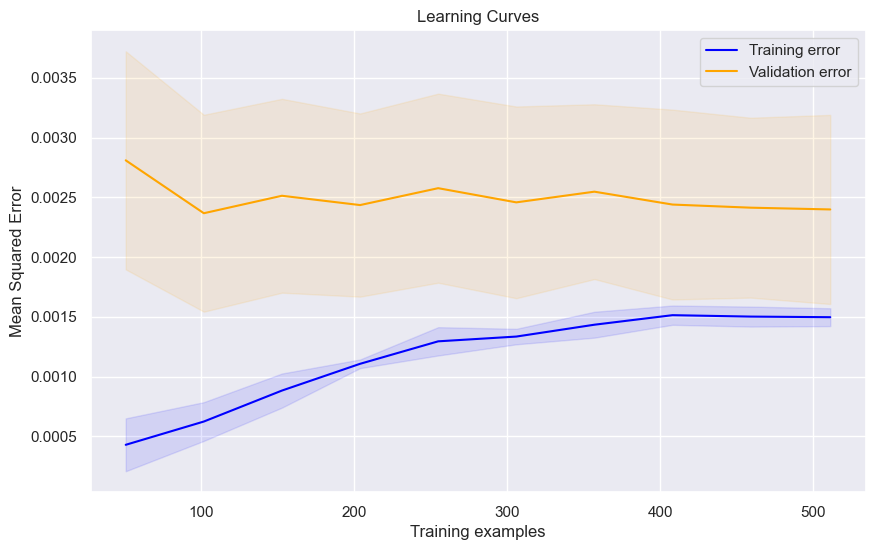

In [115]:
model = XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=200)
plot_learning_curves(model, X_train, y_train)

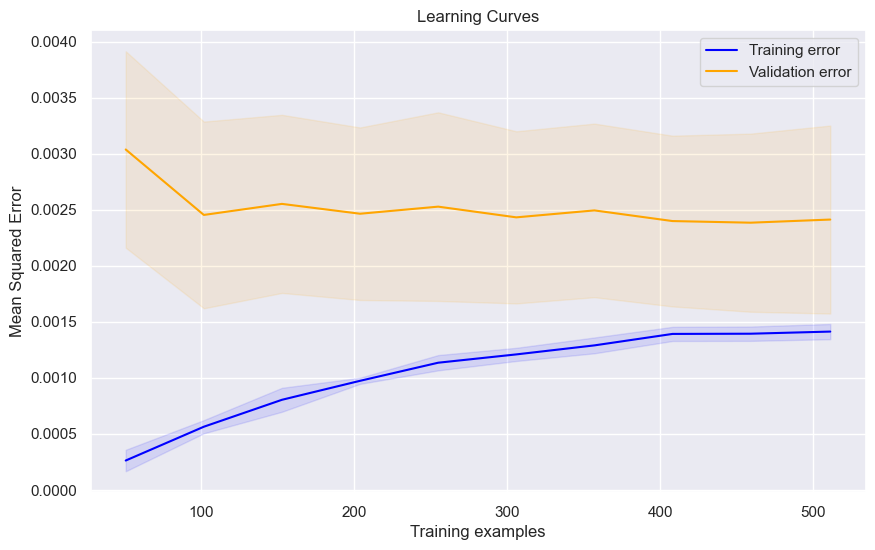

In [116]:
model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=200)
plot_learning_curves(model, X_train, y_train)

In [117]:
best_models['Gradient Boosting Regression'].named_steps['grid_search'].best_estimator_

KeyError: 'Gradient Boosting Regression'